# NEWS Aggregator

Copyright @ 2020 **ABCOM Information Systems Pvt. Ltd.** All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.

# ===================================================================


### Named Entity Recognition (NER) using LSTMs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading data

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/abcom-mltutorials/NEWSAggregator/master/ner_dataset.csv',encoding='latin1')
data=data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [ ]:
data.columns=['sentence',"Word",'POS',"Tag"]

In [ ]:
print("Sentence #2:"," ".join(data[data.sentence=='Sentence: 2'].Word.tolist()))

Sentence #2: Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "


In [ ]:
print("Sentence #5:"," ".join(data[data.sentence=='Sentence: 5'].Word.tolist()))

Sentence #5: The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .


In [ ]:
words=list(set(data["Word"].values))
words.append("ENDPAD") #end padding to make the sentences equal length
num_words=len(words)
tags=list(set(data["Tag"].values))
num_tags=len(tags)
print ("Number of unique words: ", num_words)
print ("Number of unique tags: ", num_tags)

Number of unique words:  35179
Number of unique tags:  17


### Preparing data

w is word

p is part of speech

t is tag

Each sentence is a list of tuples.

In [ ]:
def sentencegetter(data):
  agg_func=lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s['Tag'].values.tolist())]
  grouped=data.groupby("sentence").apply(agg_func)
  sentences=[s for s in grouped]
  return sentences

In [ ]:
sentences=sentencegetter(data)

In [ ]:
sentences[0] 

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

## Indexing words and tags


In [ ]:
word2idx={w:i+1 for i , w in enumerate(words)} #i+1 as we created endpad 
tag2idx={t:i for i,t in enumerate(tags)}

In [ ]:
tag2idx

{'B-art': 7,
 'B-eve': 6,
 'B-geo': 10,
 'B-gpe': 12,
 'B-nat': 15,
 'B-org': 13,
 'B-per': 14,
 'B-tim': 9,
 'I-art': 1,
 'I-eve': 0,
 'I-geo': 3,
 'I-gpe': 5,
 'I-nat': 4,
 'I-org': 16,
 'I-per': 11,
 'I-tim': 8,
 'O': 2}

## Padding input sequences

### Sentence length distribution

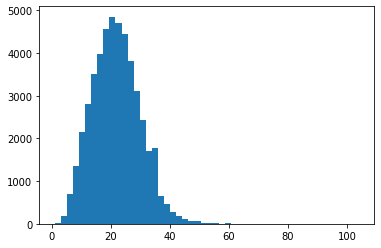

In [ ]:
#histogram of length of sentences
plt.hist([len(s) for s in sentences],bins=50) 
plt.show()

### Replacing text with index and padding to 50 length.

In [ ]:
max_len= 50
X= [[word2idx[w[0]] for w in s ] for s in sentences]
X=pad_sequences(maxlen=max_len,sequences=X,padding="post", value=num_words-1)

In [ ]:
X[1]

array([33955, 26985, 30223,  4857, 29087, 26669, 32840, 11280, 26669,
       20078, 32757, 11965, 26941, 29085,  1467,  5693, 10897, 32156,
       30169, 10405, 27874, 13521, 16014, 29107, 18156, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [ ]:
#target vector
y=[[tag2idx[w[2]] for w in s ] for s in sentences]
y=pad_sequences(maxlen=max_len,sequences=y,padding="post",value=tag2idx["O"])
y=[to_categorical(i,num_classes=num_tags) for i in y] #one hot encoding the target tag

In [ ]:
y[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

# Creating training/testing datasets

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)

# Model building

In [ ]:
input_word=Input(shape=(max_len,)) #input layer
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model= SpatialDropout1D(0.1)(model) #regularization
# bidirectional for learning across the entire sequence
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model) 
out=TimeDistributed(Dense(num_tags,activation="softmax"))(model)
model=Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


# Model compiling

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

# Model training

In [ ]:
early_stopping=EarlyStopping(monitor="val_accuracy",patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[early_stopping]
history=model.fit(xtrain,np.array(ytrain),validation_split=0.2,batch_size=32,epochs=10,verbose=1,callbacks=callbacks)

Epoch 1/10
1080/1080 [==============================] - 327s 303ms/step - loss: 0.1934 - accuracy: 0.9562 - val_loss: 0.0694 - val_accuracy: 0.9803
Epoch 2/10
1080/1080 [==============================] - 327s 303ms/step - loss: 0.0530 - accuracy: 0.9845 - val_loss: 0.0511 - val_accuracy: 0.9846
Epoch 3/10
1080/1080 [==============================] - 325s 301ms/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.0464 - val_accuracy: 0.9859
Epoch 4/10
1080/1080 [==============================] - 332s 307ms/step - loss: 0.0312 - accuracy: 0.9903 - val_loss: 0.0470 - val_accuracy: 0.9860
Epoch 5/10
1080/1080 [==============================] - 327s 303ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.0481 - val_accuracy: 0.9860


# Model evaluation

In [ ]:
model.evaluate(xtest,np.array(ytest))

150/150 [==============================] - 3s 23ms/step - loss: 0.0495 - accuracy: 0.9857


[0.04953761771321297, 0.9856964349746704]

# Inference

In [ ]:
i =np.random.randint(0,xtest.shape[0]) #to take the rndom values from the test
p=model.predict(np.array([xtest[i]]))
p=np.argmax(p,axis=-1) 

y_true=np.argmax(np.array(ytest),axis=-1)[i]

print("{:15}{:5}\t {}\n".format("word","True","pred"))
print("-"*30)

for w,true,pred in zip(xtest[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

word           True 	 pred

------------------------------
Afghan         B-gpe	B-gpe
police         O	O
say            O	O
suspected      O	O
Taleban        B-org	B-org
fighters       O	O
have           O	O
killed         O	O
five           O	O
police         O	O
officers       O	O
in             O	O
an             O	O
ambush         O	O
in             O	O
southern       B-geo	B-geo
Afghanistan    I-geo	B-geo
.              O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O	O
Le             O

# Predicting on an unseen sentence

In [ ]:
sentence="About 1,500 doctors , scientists and health workers are expected to attend the week-long Pan-Africa malaria conference in Cameroon 's capital , Yaounde "

First we convert it into index valued sequence

In [ ]:
seq=[]
for word in sentence.split():
  if word in list(word2idx.keys()):
    idx=word2idx[word]
    seq.append(idx)

Pad it to the maximum length

In [ ]:
pad_seq=pad_sequences([seq],padding='post',maxlen=50)

Do predictions

In [ ]:
p=model.predict(pad_seq)
p=np.argmax(p,axis=-1) 

In [ ]:
print("{:10}\t {}\n".format("word","pred"))
print("-"*30)
for w,pred in zip(pad_seq.tolist()[0],p[0]):
  print("{:10}\t{}".format(words[w-1],tags[pred]))

word      	 pred

------------------------------
About     	O
1,500     	O
doctors   	O
,         	O
scientists	O
and       	O
health    	O
workers   	O
are       	O
expected  	O
to        	O
attend    	O
the       	O
week-long 	B-tim
Pan-Africa	O
malaria   	O
conference	O
in        	O
Cameroon  	B-geo
's        	O
capital   	O
,         	O
Yaounde   	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
